In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import zipfile
import os
import re
import nltk
import scipy
import joblib

In [27]:
zipfile_path=r"C:\Users\syedt\Downloads\archive (3).zip"
extract_path=r"C:\Users\syedt\Downloads\movie_dataset"
with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [28]:
print(extract_path)

C:\Users\syedt\Downloads\movie_dataset


In [4]:
train_path=r"C:\Users\syedt\Downloads\movie_dataset\Genre Classification Dataset\train_data.txt"
data=pd.read_csv(train_path,sep=" ::: ",engine="python",header=None,names=["id","title","genre","plot"])

In [5]:
data.head()


,id,title,genre,plot
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [6]:
data.shape

(54214, 4)

In [26]:
print(data['genre'].value_counts())

genre
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
mystery          319
musical          277
biography        265
history          243
game-show        194
news             181
war              132
Name: count, dtype: int64


In [8]:
data[data['plot'].isna()]

,id,title,genre,plot


In [9]:
data=data.dropna(subset=['plot']).reset_index(drop=True)
data=data.drop_duplicates(subset=['title','plot']).reset_index(drop=True)
missing_count=data['plot'].isna().sum()

In [10]:
missing_count

np.int64(0)

In [11]:
len(data)

54214

In [12]:
data

,id,title,genre,plot
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The siste...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and have...


In [13]:
nltk.download(['stopwords','wordnet'])
stop=set(stopwords.words('english'))
lem=WordNetLemmatizer()
def clean_text(text):
    if not isinstance(text,str):
        return ""
    text=text.lower()
    text=re.sub(r'[^a-z\s]',' ',text)
    tokens=[t for t in text.split() if t not in stop and len(t)>2]
    tokens=[lem.lemmatize(t) for t in tokens]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syedt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\syedt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
data['clean_plot']=data['plot'].apply(clean_text)

In [15]:
X = data['clean_plot']
y = data['genre']

In [16]:
X.shape,y.shape

((54214,), (54214,))

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

In [18]:
len(X_train),len(X_test)

(43371, 10843)

In [19]:
pipe=Pipeline([('tfidf',TfidfVectorizer(stop_words='english')),('clf',LinearSVC())])
params={'tfidf__max_features':[10000,20000,30000],'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__min_df':[3, 5, 10],'clf__class_weight':[None,'balanced'],'clf__C':[0.1, 1, 10]}
search=RandomizedSearchCV(pipe,params,n_iter=20,cv=5,scoring='f1_macro',n_jobs=-1,random_state=42)
search.fit(X,y)
print("Params:",search.best_params_)
print("F1 Score:",search.best_score_)
model=search.best_estimator_

Params: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 5, 'tfidf__max_features': 30000, 'clf__class_weight': 'balanced', 'clf__C': 1}
F1 Score: 0.3591268572806588


In [20]:
y_pred=model.predict(X_test)

Classification Report:               precision    recall  f1-score   support

      action       0.86      0.99      0.92       263
       adult       0.89      1.00      0.94       118
   adventure       0.89      1.00      0.94       155
   animation       0.90      1.00      0.95       100
   biography       0.96      1.00      0.98        53
      comedy       0.91      0.90      0.91      1490
       crime       0.86      1.00      0.93       101
 documentary       0.94      0.92      0.93      2619
       drama       0.95      0.85      0.89      2723
      family       0.86      1.00      0.92       157
     fantasy       0.82      1.00      0.90        65
   game-show       0.93      1.00      0.96        39
     history       0.91      1.00      0.95        49
      horror       0.92      1.00      0.96       441
       music       0.84      1.00      0.92       146
     musical       0.90      1.00      0.95        55
     mystery       0.90      1.00      0.95        64
    

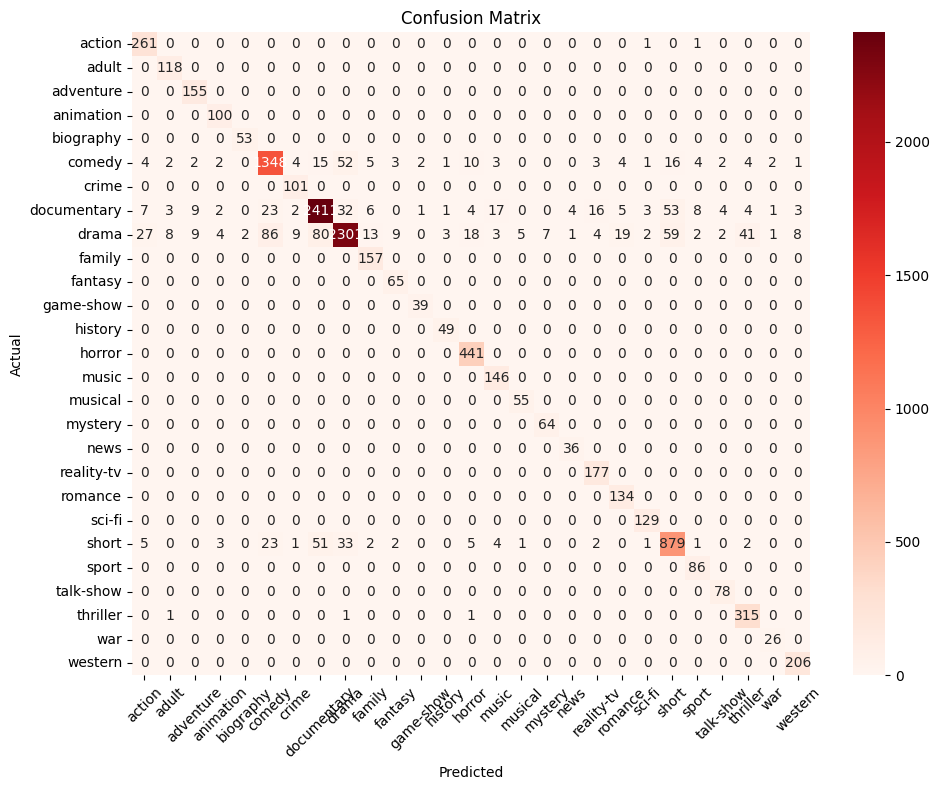

In [21]:
print("Classification Report:",classification_report(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred,labels=model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Reds',xticklabels=model.classes_,yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

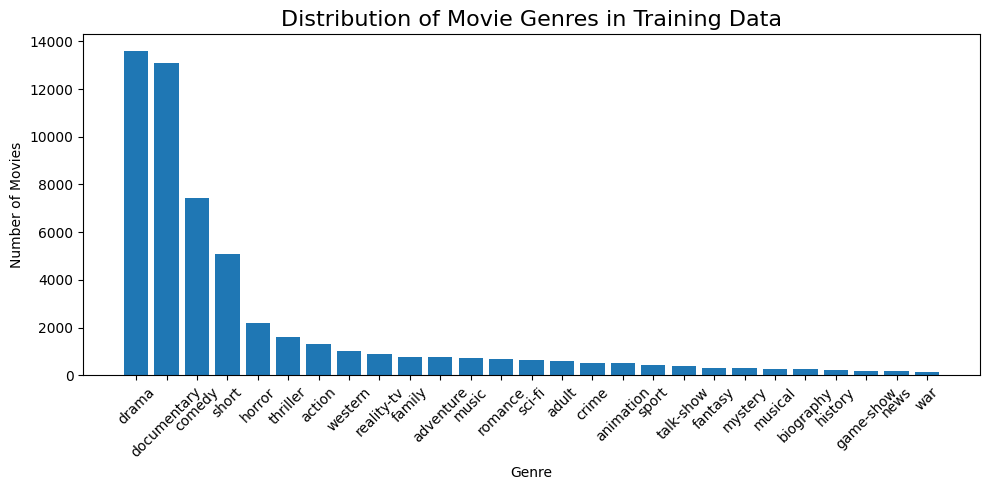

In [22]:
genre=data['genre'].value_counts()
plt.figure(figsize=(10,5))
plt.bar(genre.index,genre.values)
plt.title("Distribution of Movie Genres in Training Data",fontsize=16)
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
sample="A soldier fights monsters to save his friends"
c_sample=clean_text(sample)
pred_genre=model.predict([c_sample])[0]
print("Predicted Genre:", pred_genre)

Predicted Genre: animation


In [24]:
accuracy=accuracy_score(y_test,y_pred)
print("Model Accuracy:",accuracy)

Model Accuracy: 0.9157982108272619


In [25]:
joblib.dump(model,"movie_genre_model.joblib")
print("Model saved successfully!")

Model saved successfully!
